In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ADAUSDT.csv')
df1=df.reset_index()['Close']
df1 = df1[::-1]

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 105ms/step - loss: 0.0402 - val_loss: 0.0053
Epoch 2/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0077 - val_loss: 0.0016
Epoch 3/100
13/13 [==============================] - 1s 60ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/100
13/13 [==============================] - 1s 58ms/step - loss: 8.8725e-04 - val_loss: 0.0015
Epoch 5/100
13/13 [==============================] - 1s 59ms/step - loss: 8.1264e-04 - val_loss: 0.0017
Epoch 6/100
13/13 [==============================] - 1s 60ms/step - loss: 7.3371e-04 - val_loss: 0.0018
Epoch 7/100
13/13 [==============================] - 1s 61ms/step - loss: 7.1754e-04 - val_loss: 0.0016
Epoch 8/100
13/13 [==============================] - 1s 60ms/step - loss: 7.0544e-04 - val_loss: 0.0015
Epoch 9/100
13/13 [==============================] - 1s 60ms/step - loss: 6.8145e-04 - val_loss: 0.0016
Epoch 10/100
13/13 [==============================] - 1s 59ms/step - loss: 

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 12ms/step


In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', mae)


Validation RMSE: 0.02843417474257725
Testing RMSE: 0.16118617807506
Testing MAE: 0.019293310976694126


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=239
i=0
while(i<30):

    if(len(temp_input)>239 ):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.16072035 0.16207951 0.16207951 0.16785593 0.16581719 0.17159361
 0.17465172 0.16649677 0.17465172 0.17227319 0.17567108 0.18212708
 0.18586476 0.17906898 0.1814475  0.17499151 0.16615698 0.14509004
 0.14542983 0.14950731 0.14916752 0.15052667 0.14780836 0.15018688
 0.13897384 0.14509004 0.13795447 0.14509004 0.14610941 0.14373089
 0.14780836 0.1464492  0.15528372 0.16309888 0.16139993 0.14950731
 0.15494393 0.15494393 0.16275909 0.16615698 0.1654774  0.1624193
 0.14984709 0.15562351 0.15052667 0.15358478 0.15732246 0.14441047
 0.14610941 0.14237173 0.14135236 0.14780836 0.14916752 0.14542983
 0.14373089 0.14407068 0.14203194 0.14033299 0.14101257 0.1399932
 0.13829426 0.13455657 0.13761468 0.1399932  0.13863405 0.13795447
 0.13625552 0.13557594 0.13591573 0.12844037 0.12504247 0.12164458
 0.12028542 0.11688753 0.11586816 0.1179069  0.11858648 0.11518858
 0.11111111 0.10771322 0.11077132 0.1114509  0.11518858 0.11348964
 0.12810058 0.12911995 0.12402311 0.12945973 0.13489

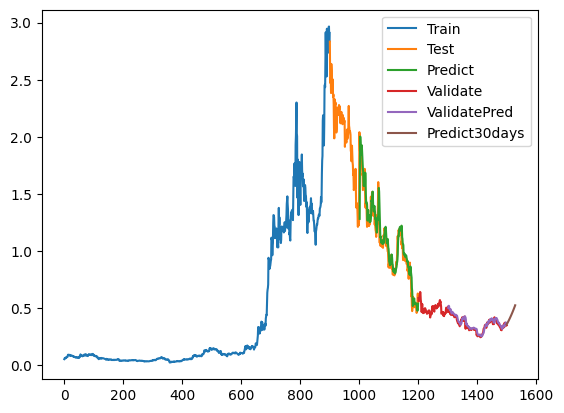

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()